In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

import os
import numpy as np
from skimage.io import imread

import time
import copy

import matplotlib.pyplot as plt

In [3]:
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'PG Project'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)

In [4]:
class MOCRNN(nn.Module):
    def __init__(self):
        super(MOCRNN, self).__init__()

        # Convolutional Block 1
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(1, 128, kernel_size=5, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=5, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )

        self.conv_block3 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=4, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )


        # Flattening layer
        self.flatten = nn.Flatten()  # Flatten layer

        # Fully connected layers for regression outputs
        self.fc1 = nn.Linear(53824 , 1024) #53824, 128
        self.relu_fc1 = nn.ReLU()
        self.fc2 = nn.Linear(1024, 512) # 128, 64
        self.relu_fc2 = nn.ReLU()
        self.fc3 = nn.Linear(512, 48) # 64, 48

    def forward(self, x):
        # Convolutional Blocks
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)

        # Flatten the feature map
        x = self.flatten(x)

        # Fully connected layers for regression
        x = self.relu_fc1(self.fc1(x))  # Apply ReLU to the first FC layer
        x = self.relu_fc2(self.fc2(x))  # Apply ReLU to the second FC layer
        x = self.fc3(x)

        return x

In [ ]:
class CustomDataset(Dataset):
  def __init__(self, images_path, labels_matrix):
    self.images_path = images_path
    self.labels = labels_matrix

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    row = self.labels[idx]
    image = torch.from_numpy(np.array(imread(os.path.join(self.images_path, f"{int(row[0])}.png"))).astype(float))
    image = image / 255.0
    if len(image.shape) == 2:
            image = image[np.newaxis, :, :]
    label = torch.from_numpy(row[1:])

    return image, label

In [ ]:
from sklearn.metrics import mean_squared_error

def train_MOCRNN(device, model, criterion, optimizer, scheduler, epochs, data_loader, datasizes):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    lowest_mse = float('inf')

    for epoch in range(epochs):
        print(f"Epoch: {epoch}/{epochs - 1}")

        for phase in ['train', 'valid']:
            # set model mode based on if it's training or validating
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_mse = 0.0

            for batch in data_loader[phase]:
                inputs, outputs = batch
                inputs = inputs.float()
                outputs = outputs.float()
                inputs = inputs.to(device)
                outputs = outputs.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss = criterion(preds, outputs).float()

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item()
                running_mse += torch.nn.functional.mse_loss(outputs, preds).item()

            epoch_loss = running_loss / datasizes[phase]
            epoch_mse = running_mse / datasizes[phase]

            if phase == 'valid':
                scheduler.step(epoch_loss)

            print(f"{phase} loss: {epoch_loss:.4f}")

            if phase == 'valid' and epoch_mse <= lowest_mse:
                lowest_mse = epoch_mse
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best MSE: {lowest_mse:.4f}")

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [5]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def test_MOCRNN(model, true_labels, test_inputs):

  # Perform inference
  with torch.no_grad():
    model.eval()  # Set the model to evaluation mode
    predictions = model(test_inputs)

  # Calculate evaluation metrics
  mae = mean_absolute_error(true_labels, predictions)
  mse = mean_squared_error(true_labels, predictions)
  rmse = np.sqrt(mse)
  r2 = r2_score(true_labels, predictions)

  print(f"Mean Absolute Error (MAE): {mae}")
  print(f"Mean Squared Error (MSE): {mse}")
  print(f"Root Mean Squared Error (RMSE): {rmse}")
  print(f"R-squared (R²): {r2}")

  return predictions

In [6]:
outputs_path = os.path.join(GOOGLE_DRIVE_PATH, 'training_data/train_data.csv')
inputs_path = os.path.join(GOOGLE_DRIVE_PATH, 'training_data/images')

# Copy it to Colab
!cp -r '{inputs_path}' .

In [ ]:


#get the outputs / labels
outputs_data = np.genfromtxt(outputs_path, delimiter=',', dtype=float)
print(outputs_data.shape)

train_valid_split = 0.9

train_valid_idx = int(outputs_data.shape[0] * train_valid_split)

valid_y = outputs_data[train_valid_idx:]
train_y = outputs_data[:train_valid_idx]

# create datasets

train_dataset = CustomDataset('images', train_y)
valid_dataset = CustomDataset('images', valid_y)

# get Datasets sizes

data_sizes = {
    'train': train_y.shape[0],
    'valid': valid_y.shape[0],
}

# create dataloader

data_loader = {
    'train': DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2),
    'valid': DataLoader(valid_dataset, batch_size=32, shuffle=True, num_workers=2)
}

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

In [ ]:
# Create an instance of the network
mocrnn = MOCRNN()
mocrnn = mocrnn.to(device)

criterion = nn.HuberLoss()

optimizer = torch.optim.NAdam(mocrnn.parameters())

scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=False)

# train_MOCRNN params: device, model, criterion, optimizer, scheduler, epochs, dataloader, datasizes
model = train_MOCRNN(device, mocrnn, criterion, optimizer, scheduler, 50, data_loader, data_sizes)


In [ ]:
name = 'MOCRNN_Model_1'
models_path = os.path.join(GOOGLE_DRIVE_PATH, 'models')
save_path = os.path.join(models_path, f'{name}.pt')

In [ ]:
example = torch.rand(1, 1, 256, 256)
model = model.to('cpu')
# Use torch.jit.trace to generate a torch.jit.ScriptModule via tracing.
traced_script_module = torch.jit.trace(model, example)


traced_script_module.save(save_path)

In [10]:
test_path = os.path.join(GOOGLE_DRIVE_PATH, 'training_data/test_data.csv')
test_data = np.genfromtxt(test_path, delimiter=',', dtype=float)
labels_tensor = torch.tensor([])
inputs_tensor = torch.tensor([])

for row in test_data:
  image = np.array(imread(os.path.join("images/", f"{int(row[0])}.png"))).astype(float)
  image = image / 255.0
  if len(image.shape) == 2:
    image = image[np.newaxis, :, :]

  image = torch.from_numpy(image).float()
  label = torch.from_numpy(row[1:]).float()
  labels_tensor = torch.cat((labels_tensor, label), dim=0)
  inputs_tensor = torch.cat((inputs_tensor, image), dim=0)


In [11]:
labels_tensor = labels_tensor.view(295, 48)
labels_tensor.shape

torch.Size([295, 48])

In [12]:
inputs_tensor = torch.unsqueeze(inputs_tensor, dim=1)

inputs_tensor.shape

torch.Size([295, 1, 256, 256])

In [13]:

models_path = os.path.join(GOOGLE_DRIVE_PATH, 'models')
model_1_path = os.path.join(models_path, 'MOCRNN_Model_1.pt')
model_2_path = os.path.join(models_path, 'MOCRNN_Model_2.pt')

In [14]:
model_1 = torch.jit.load(model_1_path)
model_1.eval()
model_1.float()
model_2 = torch.jit.load(model_2_path)
model_2.eval()
model_2.float()

print('1')
preds_1 = test_MOCRNN(model_1, labels_tensor, inputs_tensor)
print('2')
preds_2 = test_MOCRNN(model_2, labels_tensor, inputs_tensor)

1
Mean Absolute Error (MAE): 0.1876436024904251
Mean Squared Error (MSE): 0.07434490323066711
Root Mean Squared Error (RMSE): 0.27266260981559753
R-squared (R²): 0.30089238360695036
2
Mean Absolute Error (MAE): 0.21783830225467682
Mean Squared Error (MSE): 0.08844327181577682
Root Mean Squared Error (RMSE): 0.29739412665367126
R-squared (R²): 0.0946318514175339


MOCRNN_Model_1:

Mean Absolute Error (MAE): 0.1876436024904251

Mean Squared Error (MSE): 0.07434490323066711

Root Mean Squared Error (RMSE): 0.27266260981559753

R-squared (R²): 0.30089238360695036

MOCRNN_Model_2:

Mean Absolute Error (MAE): 0.21783830225467682

Mean Squared Error (MSE): 0.08844327926635742

Root Mean Squared Error (RMSE): 0.29739415645599365

R-squared (R²): 0.09463186893173366

In [15]:
tru = labels_tensor.numpy().T
pr1 = preds_1.numpy().T
pr2 = preds_2.numpy().T

In [18]:
tru_x = []
tru_y = []
tru_z = []

pr1_x = []
pr1_y = []
pr1_z = []

pr2_x = []
pr2_y = []
pr2_z = []

for i in range(16):
  tru_x.append(tru[i])
  tru_y.append(tru[i + 1])
  tru_z.append(tru[i + 2])

  pr1_x.append(pr1[i])
  pr1_y.append(pr1[i + 1])
  pr1_z.append(pr1[i + 2])

  pr2_x.append(pr2[i])
  pr2_y.append(pr2[i + 1])
  pr2_z.append(pr2[i + 2])

tru_x = np.array(tru_x).flatten()
tru_y = np.array(tru_y).flatten()
tru_z = np.array(tru_z).flatten()

pr1_x = np.array(pr1_x).flatten()
pr1_y = np.array(pr1_y).flatten()
pr1_z = np.array(pr1_z).flatten()

pr2_x = np.array(pr2_x).flatten()
pr2_y = np.array(pr2_y).flatten()
pr2_z = np.array(pr2_z).flatten()


In [19]:
print('1 x:', r2_score(tru_x, pr1_x))
print('1 y:', r2_score(tru_y, pr1_y))
print('1 z:', r2_score(tru_z, pr1_z))
print('2 x:', r2_score(tru_x, pr2_x))
print('2 y:', r2_score(tru_y, pr2_y))
print('2 z:', r2_score(tru_z, pr2_z))

1 x: 0.42660339063966746
1 y: 0.43669731447958215
1 z: 0.4298664163409053
2 x: 0.28426217971514534
2 y: 0.2984215795729048
2 z: 0.2957450282544182


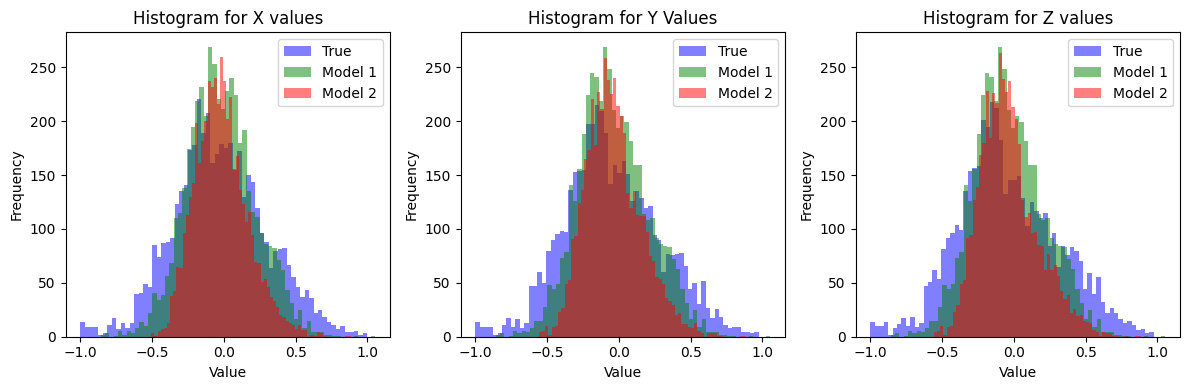

In [14]:
# Create separate charts for each list
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Create histograms for each list and add them to the respective chart
axs[0].hist(tru_x, bins=64, alpha=0.5, color='blue', label='True')
axs[0].hist(pr1_x, bins=64, alpha=0.5, color='green', label='Model 1')
axs[0].hist(pr2_x, bins=64, alpha=0.5, color='red', label='Model 2')
axs[0].set_title('Histogram for X values')
axs[0].set_xlabel('Value')
axs[0].set_ylabel('Frequency')
axs[0].legend()

axs[1].hist(tru_y, bins=64, alpha=0.5, color='blue', label='True')
axs[1].hist(pr1_y, bins=64, alpha=0.5, color='green', label='Model 1')
axs[1].hist(pr2_y, bins=64, alpha=0.5, color='red', label='Model 2')
axs[1].set_title('Histogram for Y Values')
axs[1].set_xlabel('Value')
axs[1].set_ylabel('Frequency')
axs[1].legend()

axs[2].hist(tru_z, bins=64, alpha=0.5, color='blue', label='True')
axs[2].hist(pr1_z, bins=64, alpha=0.5, color='green', label='Model 1')
axs[2].hist(pr2_z, bins=64, alpha=0.5, color='red', label='Model 2')
axs[2].set_title('Histogram for Z values')
axs[2].set_xlabel('Value')
axs[2].set_ylabel('Frequency')
axs[2].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the charts
plt.show()

[0.16753855, 0.16995496, 0.17882586] [0.20247196, 0.20525339, 0.21519701]


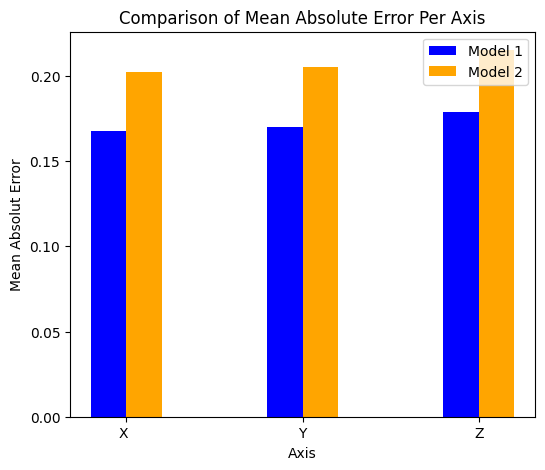

In [20]:
from sklearn.metrics import mean_absolute_error as mae

tru_all = [tru_x, tru_y, tru_z]
pr1_all = [pr1_x, pr1_y, pr1_z]
pr2_all = [pr2_x, pr2_y, pr2_z]

axis_err_1 = []
axis_err_2 = []
labels = ['X ', 'Y', 'Z']

for i in range(3):
  err1 = mae(tru_all[i], pr1_all[i])
  err2 = mae(tru_all[i], pr2_all[i])
  axis_err_1.append(err1)
  axis_err_2.append(err2)

fig, ax = plt.subplots(figsize=(6, 5))

print(axis_err_1, axis_err_2)

# Plotting the first bar graph
ax.bar(range(3), axis_err_1, width=0.2, color='blue', label='Model 1')
# Plotting the first bar graph
ax.bar([p + 0.2 for p in range(3)], axis_err_2, width=0.2, color='orange', label='Model 2')

# Set labels and title
plt.xlabel("Axis")
plt.ylabel("Mean Absolut Error")
plt.title("Comparison of Mean Absolute Error Per Axis")
ax.set_xticks([p + 0.1 for p in range(3)])
ax.set_xticklabels([p for p in labels])
ax.legend()
plt.show()

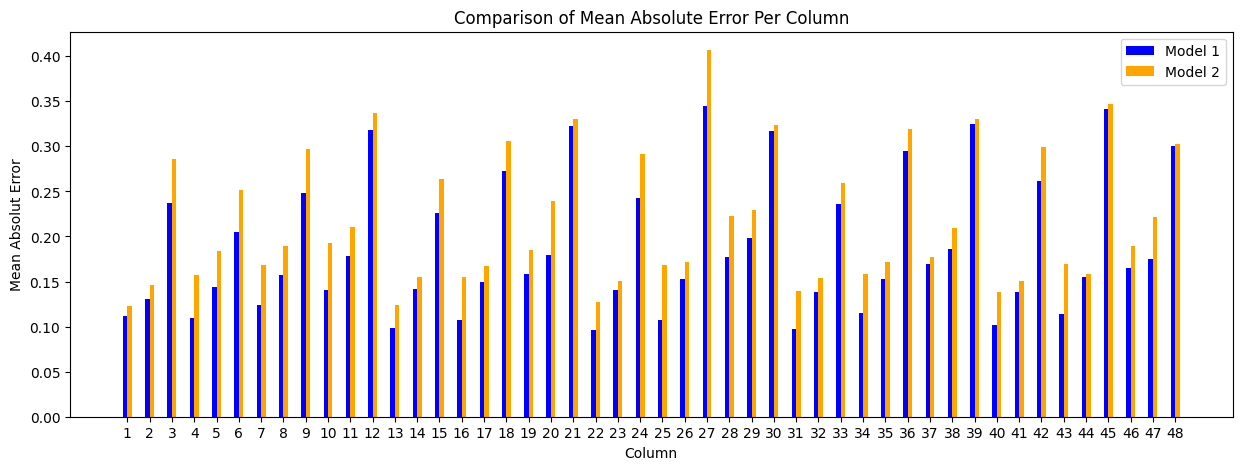

In [ ]:
pr1_mean_err_per_col = []
pr2_mean_err_per_col = []

for i in range(48):
  abs_err1 = np.array([abs(a- b) for a, b in zip(tru[i], pr1[i])])
  abs_err2 = np.array([abs(a- b) for a, b in zip(tru[i], pr2[i])])

  pr1_mean_err_per_col.append(np.mean(abs_err1))
  pr2_mean_err_per_col.append(np.mean(abs_err2))

fig, ax = plt.subplots(figsize=(15, 5))

# Plotting the first bar graph in blue color
ax.bar(range(48), pr1_mean_err_per_col, width=0.2, color='blue', label='Model 1')

# Plotting the second bar graph in orange color, slightly shifted for visibility
ax.bar([p + 0.2 for p in range(48)], pr2_mean_err_per_col, width=0.2, color='orange', label='Model 2')

# Set labels and title
plt.xlabel("Column")
plt.ylabel("Mean Absolut Error")
plt.title("Comparison of Mean Absolute Error Per Column")
ax.set_xticks([p + 0.1 for p in range(48)])
ax.set_xticklabels([p + 1 for p in range(48)])
ax.legend()
plt.show()

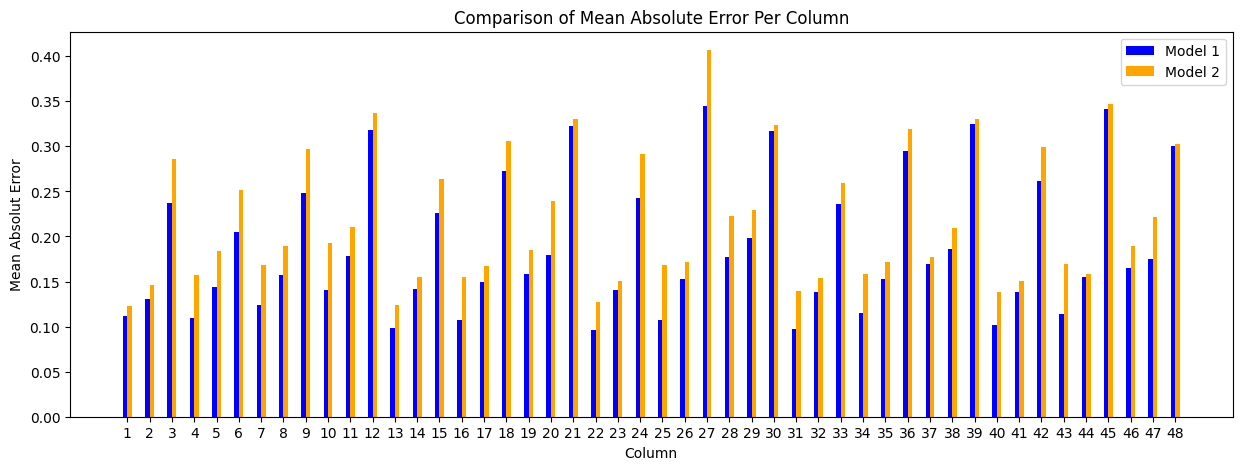

In [15]:
pr1_mean_err_per_col = []
pr2_mean_err_per_col = []

for i in range(48):
  abs_err1 = np.array([abs(a- b) for a, b in zip(tru[i], pr1[i])])
  abs_err2 = np.array([abs(a- b) for a, b in zip(tru[i], pr2[i])])

  pr1_mean_err_per_col.append(np.mean(abs_err1))
  pr2_mean_err_per_col.append(np.mean(abs_err2))

fig, ax = plt.subplots(figsize=(15, 5))

# Plotting the first bar graph in blue color
ax.bar(range(48), pr1_mean_err_per_col, width=0.2, color='blue', label='Model 1')

# Plotting the second bar graph in orange color, slightly shifted for visibility
ax.bar([p + 0.2 for p in range(48)], pr2_mean_err_per_col, width=0.2, color='orange', label='Model 2')

# Set labels and title
plt.xlabel("Column")
plt.ylabel("Mean Absolut Error")
plt.title("Comparison of Mean Absolute Error Per Column")
ax.set_xticks([p + 0.1 for p in range(48)])
ax.set_xticklabels([p + 1 for p in range(48)])
ax.legend()
plt.show()

In [ ]:
from matplotlib import rc
import matplotlib.animation as animation
rc('animation', html='jshtml')

fig, ax = plt.subplots()

def frame(i):

    x = i
    ax.clear()
    fig.tight_layout()
    plt.scatter(tru[x], pr1[x], color='blue', label='Model_1')
    plt.scatter(tru[x], pr2[x], color='red', label='Model2')
    plt.xlabel("True")
    plt.ylabel("Prediction")
    plt.title(f"Plot comparing True to Prediction values of column {x}")


    plot=plt.show()
    return plot

anim = animation.FuncAnimation(fig, frame, frames=48)
plt.close()
anim